## Calibrating an sCMOS camera 
This notebook explains how to calibrate an sCMOS camera, i.e. how to measure the offset, variance, gain and relative quantum efficiency of each pixel in the camera. The gain is determined under the assumption that the photo-electrons (e-) detected per well are Poisson distributed. This distribution has the property that it's mean is equal to it's variance.

Note:
* The Poisson assumption is not valid for an EMCCD camera due to the excess noise added by the amplification stage. However to a pretty good approximation, the variance scales as twice the mean so you'll get basically the right answer by multiplying the measured gain by 2.
* This calibration does not tell you anything about the absolute quantum efficiency of the camera, despite the occasional claim to the contrary.


### Configuring the directory
Create an empty directory somewhere on your computer and tell Python to go to that directory.

In [1]:
import os
os.chdir(r"F:\moritz\babcock_test")
print(os.getcwd())

F:\moritz\babcock_test


Generate sample data for analysis. 

Here we are just going to generate a bunch of simulated movies. In practice you would do this by taking one movie with the camera shutter closed and the other movies at different, and more or less constant illuminations. One way do this is using the bright-field lamp on the microscope and a low magnification objective (like a 10x) with no sample.

Note also that in order to measure the variance and gain to better than 1% you need to take at least 20k frames for each light intensity.

In [2]:
import numpy
import numpy.random
import pickle
import tifffile

n_frames = 4000
x_size = 60
y_size = 50
gain = numpy.random.normal(loc = 2.0, scale = 0.1, size = (x_size, y_size))
offset = numpy.random.randint(95, high = 106, size = (x_size, y_size)).astype(float)
read_noise = numpy.random.normal(loc = 1.5, scale = 0.1, size = (x_size, y_size))
c_data = [[0.0, "dark"], [1000.0, "light1"], [2000.0, "light2"], [3000, "light3"], [4000, "light4"]]
    
print("Mean offset", numpy.mean(offset))
print("Mean read noise", numpy.mean(read_noise))

def makeMovie(name, average_intensity):
    with tifffile.TiffWriter(name) as tf:
        for i in range(n_frames):
            # Signal - Poisson distribution
            image = gain * numpy.random.poisson(lam = average_intensity, size = (x_size, y_size))
        
            # Read Noise - Normal distribution
            image += numpy.random.normal(scale = read_noise, size = (x_size, y_size))
        
            # Camera baseline.        
            image += offset

            # 16 bit camera.
            tf.save(numpy.round(image).astype(numpy.uint16))
    print("Made", name)
        
for elt in c_data:
    makeMovie(elt[1] + ".tif", elt[0])
    

Mean offset 100.10966666666667
Mean read noise 1.4991095975153195


C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_13588\1322300978.py:30: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tf.save(numpy.round(image).astype(numpy.uint16))


Made dark.tif
Made light1.tif
Made light2.tif
Made light3.tif
Made light4.tif


### Calibration

Compute statistics for each movie (mean and variance) and save in the appropriate format for `camera_calibration.py`.

In [3]:
import storm_analysis.sCMOS.movie_to_calib_format as mTCF

for elt in c_data:
    bname = elt[1]
    [frame_mean, N, NN] = mTCF.movieToCalibration(bname + ".tif")
    mean = N/float(frame_mean.size)
    print("File", bname)
    print("Mean", numpy.mean(mean))
    print("Variance", numpy.mean(NN/float(frame_mean.size) - mean*mean))
    print("")
    
    with open(bname + ".npy", "wb") as fp:
        pickle.dump([frame_mean, N, NN], fp)
        

File dark
Mean 100.10950058333333
Variance 2.3389779678541887

File light1
Mean 2099.353932833333
Variance 4006.861821833484

File light2
Mean 4098.569909166667
Variance 8010.423803324641

File light3
Mean 6097.786832
Variance 12015.552780458705

File light4
Mean 8097.045195000001
Variance 16027.421624205994



Run `camera_calibration.py` to calculate the sCMOS calibration file.

['dark.npy', 'light1.npy', 'light2.npy', 'light3.npy', 'light4.npy']
0 loading dark.npy
dark.npy mean intensity variance 0.000


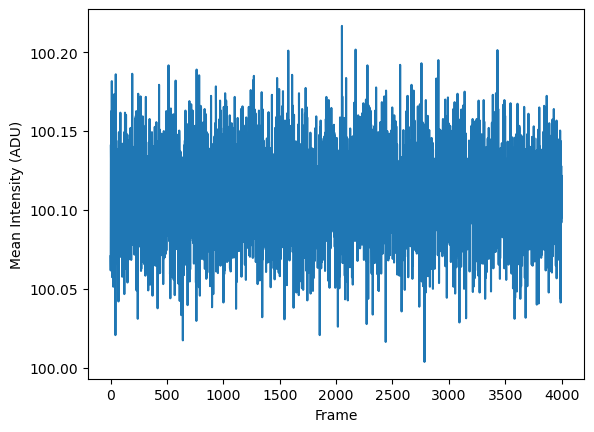

1 loading light1.npy
light1.npy mean intensity variance 1.389


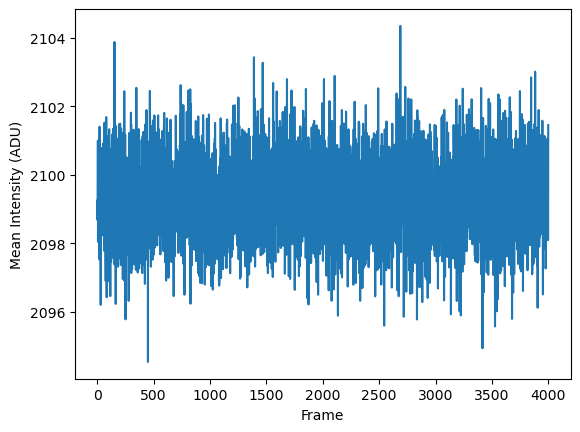

  average pixel variance 4003.134
2 loading light2.npy
light2.npy mean intensity variance 2.755


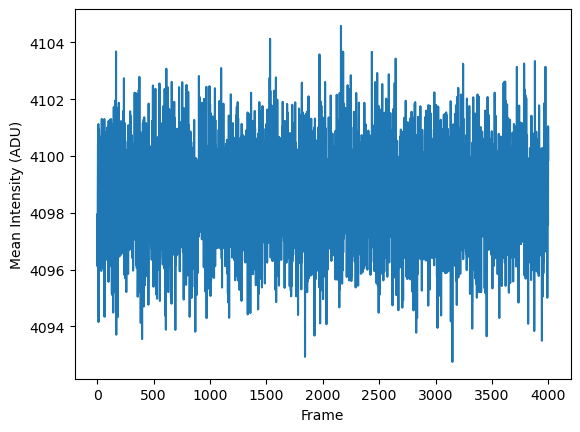

  average pixel variance 8005.330
3 loading light3.npy
light3.npy mean intensity variance 4.002


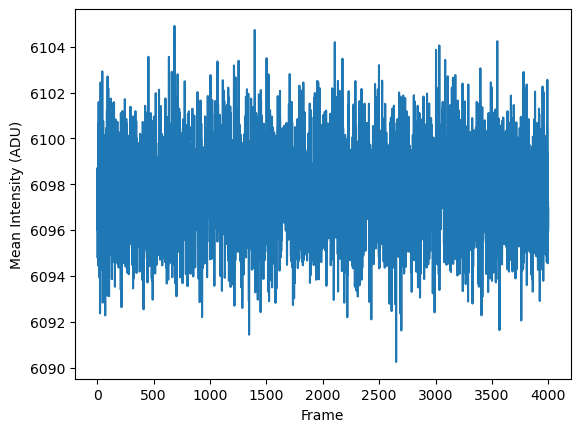

  average pixel variance 12009.212
4 loading light4.npy
light4.npy mean intensity variance 5.272


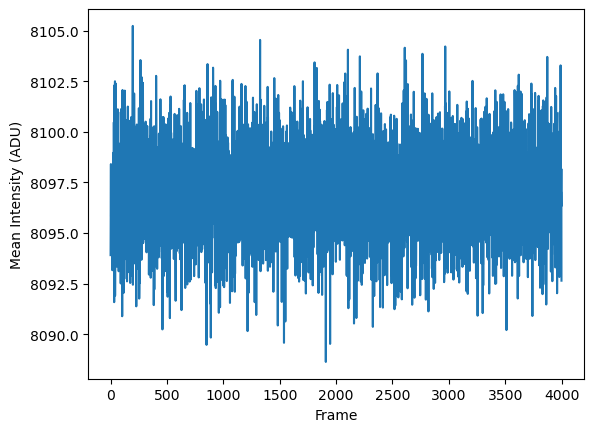

  average pixel variance 16019.811
pixel 0 0 offset 95.996 variance 2.274 gain 2.007
pixel 20 0 offset 97.997 variance 2.554 gain 1.971
pixel 40 0 offset 104.046 variance 2.844 gain 2.073

0 gain 2.007


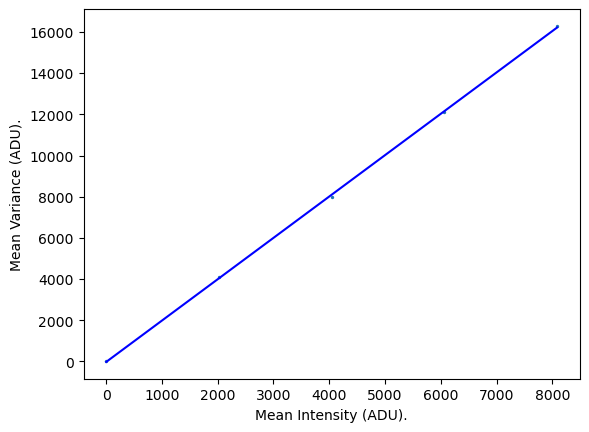

1 gain 2.129


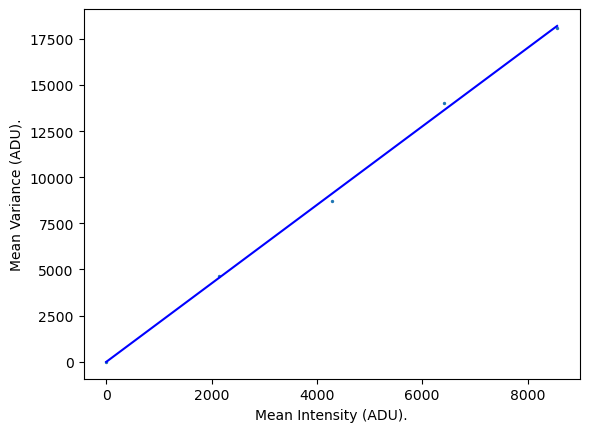

2 gain 2.045


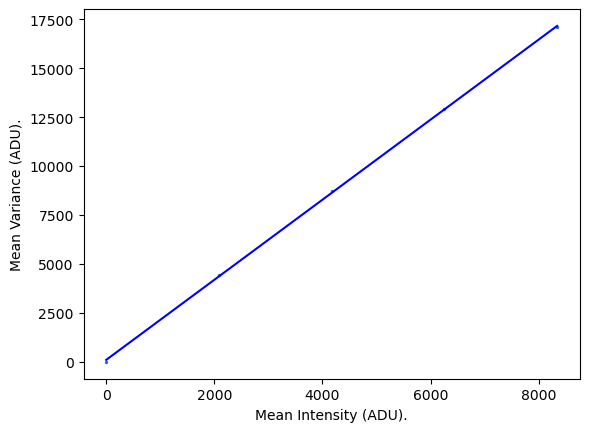

3 gain 1.749


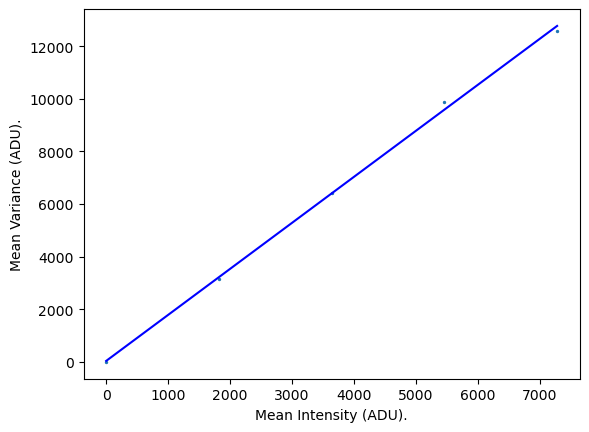

4 gain 1.900


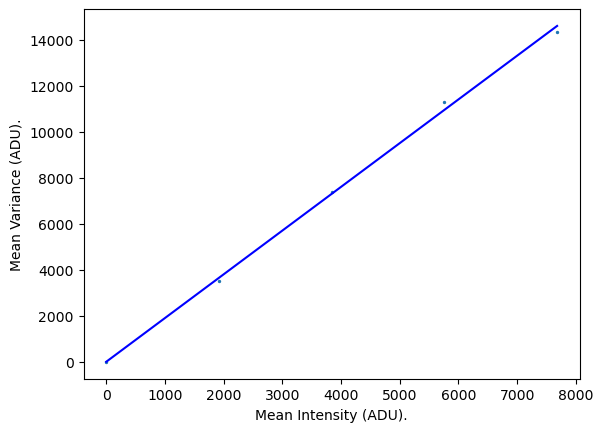

light4.npy mean intensity variance 5.272
Mean gain 1.9980920855579583


In [4]:
import storm_analysis.sCMOS.camera_calibration as cam_cal

# Note: The statistics file should be in order from dimmest to brightest.
stat_files = list(map(lambda x: x[1] + ".npy", c_data))
print(stat_files)

# Note: The relative quantum efficiency is estimated by comparing the values
# in a smoothed version of the brightest image to the raw version.
#
[m_offset, m_variance, m_gain, m_rqe] = cam_cal.cameraCalibration(stat_files)

# The '2' is a file format marker. If this is left out then sCMOS analysis
# will interpret the data incorrectly.
#
# See the function loadSCMOS calibration in the file
# storm_analysis/sa_library/analysis_io.py for details.
#
with open("calib.npy", "wb") as fp:
    pickle.dump([m_offset, m_variance, m_gain, m_rqe, 2], fp)

print("Mean gain", numpy.mean(m_gain))

### Evaluate the results

How good a job did we do measuring the calibration?

In [5]:
def makePlot(x, y, limits, xlabel, ylabel):
    fig = pyplot.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x, y, s = 4)
    ax.plot([limits[0],limits[1]],[limits[2],limits[3]], color = 'black', linewidth = 2)
    ax.axis("equal")
    ax.axis(limits)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()

Relative QE fractional measurement error: 0.019


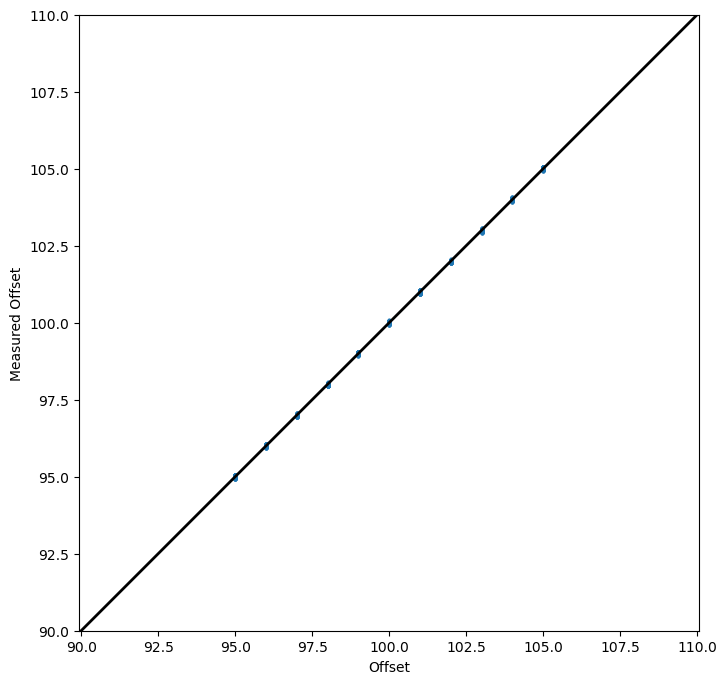

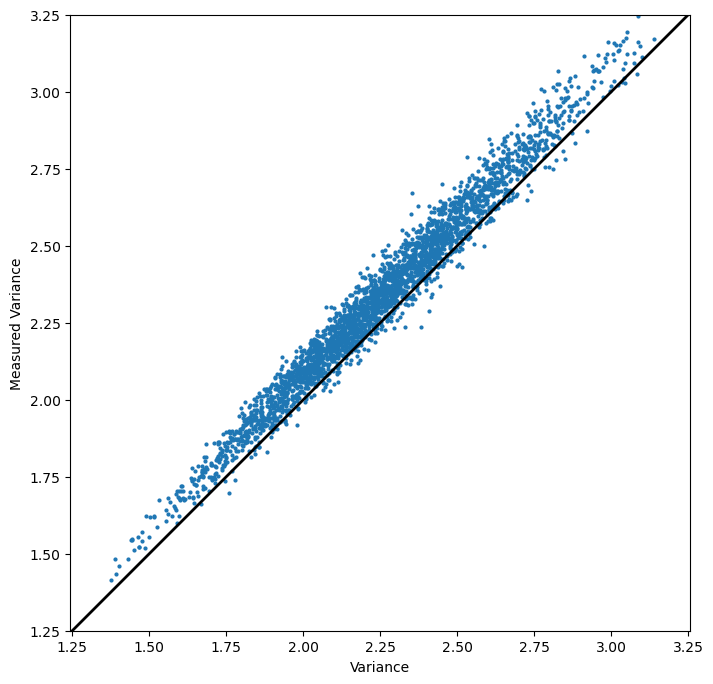

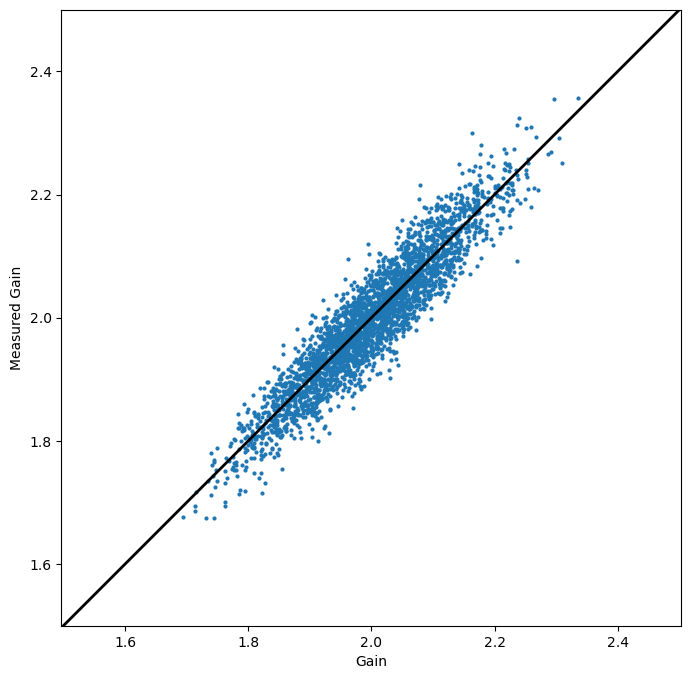

In [6]:
import matplotlib
import matplotlib.pyplot as pyplot

import storm_analysis.sa_library.analysis_io as analysisIO

rn_sqr = read_noise * read_noise

# This is the function that analysis will use to load the sCMOS calibration data.
[f_offset, f_variance, f_gain, f_rqe] = analysisIO.loadCMOSCalibration("calib.npy", verbose = True)

print("Relative QE fractional measurement error: {0:.3f}".format(numpy.std(f_rqe)))

makePlot(offset.flatten(), f_offset.flatten(), [90, 110, 90, 110], "Offset", "Measured Offset")
makePlot(rn_sqr.flatten(), f_variance.flatten(), [1.25, 3.25, 1.25, 3.25], "Variance", "Measured Variance")
makePlot(gain.flatten(), f_gain.flatten(), [1.5, 2.5, 1.5, 2.5], "Gain", "Measured Gain")



### Also

The `storm-control` setup control software (available [here](https://github.com/ZhuangLab/storm-control)) can create the statistics files directly. This avoids having to store the possibly quite large movie files.

# FROM HERE ME CHANGE & TESTING

In [36]:
import numpy as np
cal = np.load(os.path.join(os.getcwd(), 'calib_t10_0_1.npy'), allow_pickle=True)
#cal = np.load(os.path.join(os.getcwd(), 'calib.npy'), allow_pickle=True)
len(cal)

5

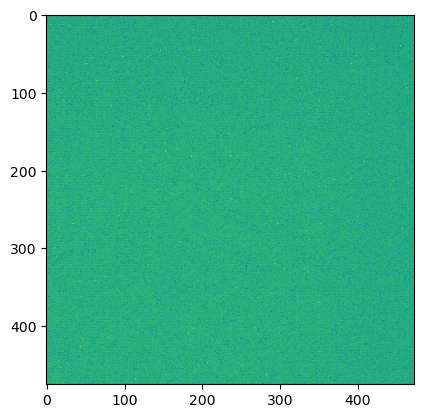

Range: 89.53070152-110.20730281


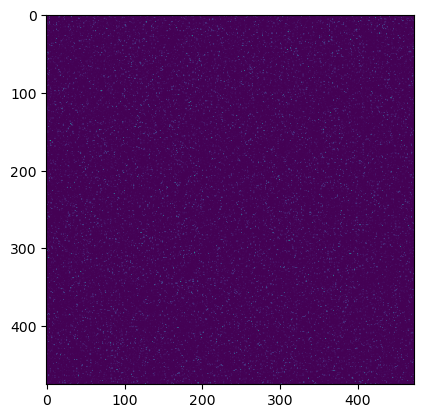

Range: 71.92654969703815-54424.371442930074


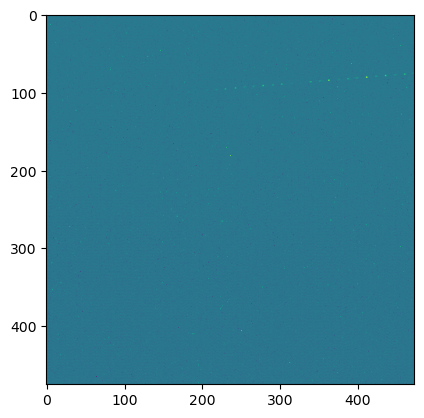

Range: -6.2294145-17.797567


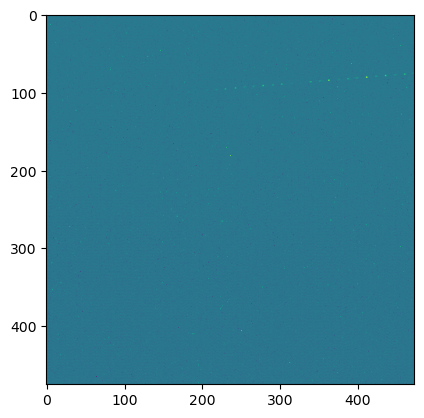

Range: -20.6253646588122-58.9270965055612


In [37]:
import matplotlib.pyplot as plt
for i in range(len(cal)-1):
    plt.imshow(cal[i])
    plt.show()
    print(f"Range: {np.min(cal[i])}-{np.max(cal[i])}")

In [25]:
cal[-1]

2